In [ ]:
## New notebook for running optimizations while working on other code

In [1]:
from math import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.io
import scipy.optimize
from scipy.fft import fft, ifft
import pandas as pd
import os
from datetime import datetime

In [2]:
def one_sec_array(Hz):
    
    # Returns a second-long row vector of "frames" (60Hz ICANDI) identifying when the stimulus is "on" in percent from 0-1
    # This func was stripped from the AOVIS_exp/+Flicker/Flkr_desensitize_2cond.m, so should match all stims in the system

    # not entirely sure how to treat the 60Hz ("always on") condition yet, since I'm using 50% power now.  I probably should use these
    # one_sec_vectors as logical arrays for when the light is on or off, and treat the 60Hz condition somewhere else in the modeling,
    # but for now, 60Hz is uses 0.5 for "on," representing the gain
    
    Stimframe = 1
    Halfstimframe = 0.5
    
    if Hz == 60:
        one_sec_vec = [Halfstimframe] * 60
    elif Hz == 30:
        one_sec_vec = [Stimframe, 0] * 30
    elif Hz == 20:
        one_sec_vec = [Stimframe, 0, 0] * 20
    elif Hz == 15:
        one_sec_vec = [Stimframe, Stimframe, 0, 0] * 15
    elif Hz == 12:
        one_sec_vec = [Stimframe, Stimframe, 0, 0, 0] * 12
    elif Hz == 10:
        one_sec_vec = [Stimframe, Stimframe, Stimframe, 0, 0, 0] * 10
    elif Hz == 6:
        one_sec_vec = [Stimframe] * 5 + [0] * 5
        one_sec_vec *= 6
    elif Hz == 5:
        one_sec_vec = [Stimframe] * 6 + [0] * 6
        one_sec_vec *= 5
    elif Hz == 3:
        one_sec_vec = [Stimframe] * 10 + [0] * 10
        one_sec_vec *= 3
    elif Hz == 2:
        one_sec_vec = [Stimframe] * 15 + [0] * 15
        one_sec_vec *= 2
    elif Hz == 1:
        one_sec_vec = [Stimframe] * 30 + [0] * 30
    elif Hz == 0:
        one_sec_vec = [0] * 60

    return one_sec_vec

# example usage: one_sec_vec15 = one_sec_array(15)

In [3]:
def pad_to_millisecond(ICANDI_vec):
    # My 31 pixel circular stims are actually displayed for ~2ms, so this converts from ICANDI 60fps stim representations
    # to 1000ms vectors of stim gain.  16.668 ms per frame at 60fps means I have to drop a millisecond every third frame
    # (17ms * 60 frames would be 1020).
    
    # Initialize the output vector
    millisec_vec = []
    
    # Iterate through each frame in the input vector
    counter = 1
    for value in ICANDI_vec:
        # If the frame is "on" (above zero), create a 2ms "on" period followed by zeros
        if value > 0:
            millisec_vec.extend([value] * 2)
            if (counter % 3) == 0:
                millisec_vec.extend([0] * 14)
            else:
                millisec_vec.extend([0] * 15)
        # If the frame is "off" (zero), create zeros for the whole frame duration
        else:
            if (counter % 3) == 0:
                millisec_vec.extend([0] * 16)
            else:
                millisec_vec.extend([0] * 17)
        counter += 1
    
    return millisec_vec
    
# Example usage:
# output_vec60 = pad_to_millisecond(one_sec_vec60)
# print(output_vec60)
# len(output_vec60)

In [4]:
def smooth_signal(signal, fps, cutoff_freq):
    # Convert cutoff frequency to sigma for Gaussian filter
    sigma = 1 / (2 * np.pi * cutoff_freq)
    
    # Calculate the length of the filter
    filter_length = int(4 * sigma * 60) #int(4* sigma * fps)
    
    # Generate Gaussian filter kernel
    kernel = scipy.signal.windows.gaussian(filter_length, sigma)
    kernel /= np.sum(kernel)  # Normalize the kernel
    
    # Apply the filter to the signal
    smoothed_signal = scipy.signal.convolve(signal, kernel, mode='same')
    
    return smoothed_signal

In [5]:
def one_sec_smoothed_signal(hz, cutoff_frequency):
    
    # combines one_sec_array(), pad_to_millisecond() and smooth_signal() into one function 
    # returns a one-second-long vector of gain values at millisecond precision
    # fps is assumed to be 60
    #
    # arguments:   Hz            (int)      freq of signal, must be evenly divisble into 60 (eg 12)
    #              cutoff_freq   (float)    see https://en.wikipedia.org/wiki/Gaussian_filter
    #                                       or just try 0.03

    an_ICANDI_vec = one_sec_array(hz)
    millisec_vec = pad_to_millisecond(an_ICANDI_vec)
    smoothed_vec = smooth_signal(millisec_vec, 60, cutoff_frequency)

    return smoothed_vec

In [8]:
# Define the differential equation function
# For now, "b" values can be selected based on the b values found in the Curve Fitting Toolbox for each frequency, 
# but I will try to optimize later.
def rate_of_desensitization(sensation, d):
    return -d * sensation

In [6]:
# open matlab file with Experiment 1 visibility data
# scipy.io.loadmat loads everything in the .mat as a dictionary

Exp1_mat = scipy.io.loadmat('data/Exp1/Exp1_minus_20204R.mat')

# Optimizing Approach 2

Optimized d: 0.25982751695496387, Optimized r: 0.12370874061195768, Optimized c: 0.025244699358998243


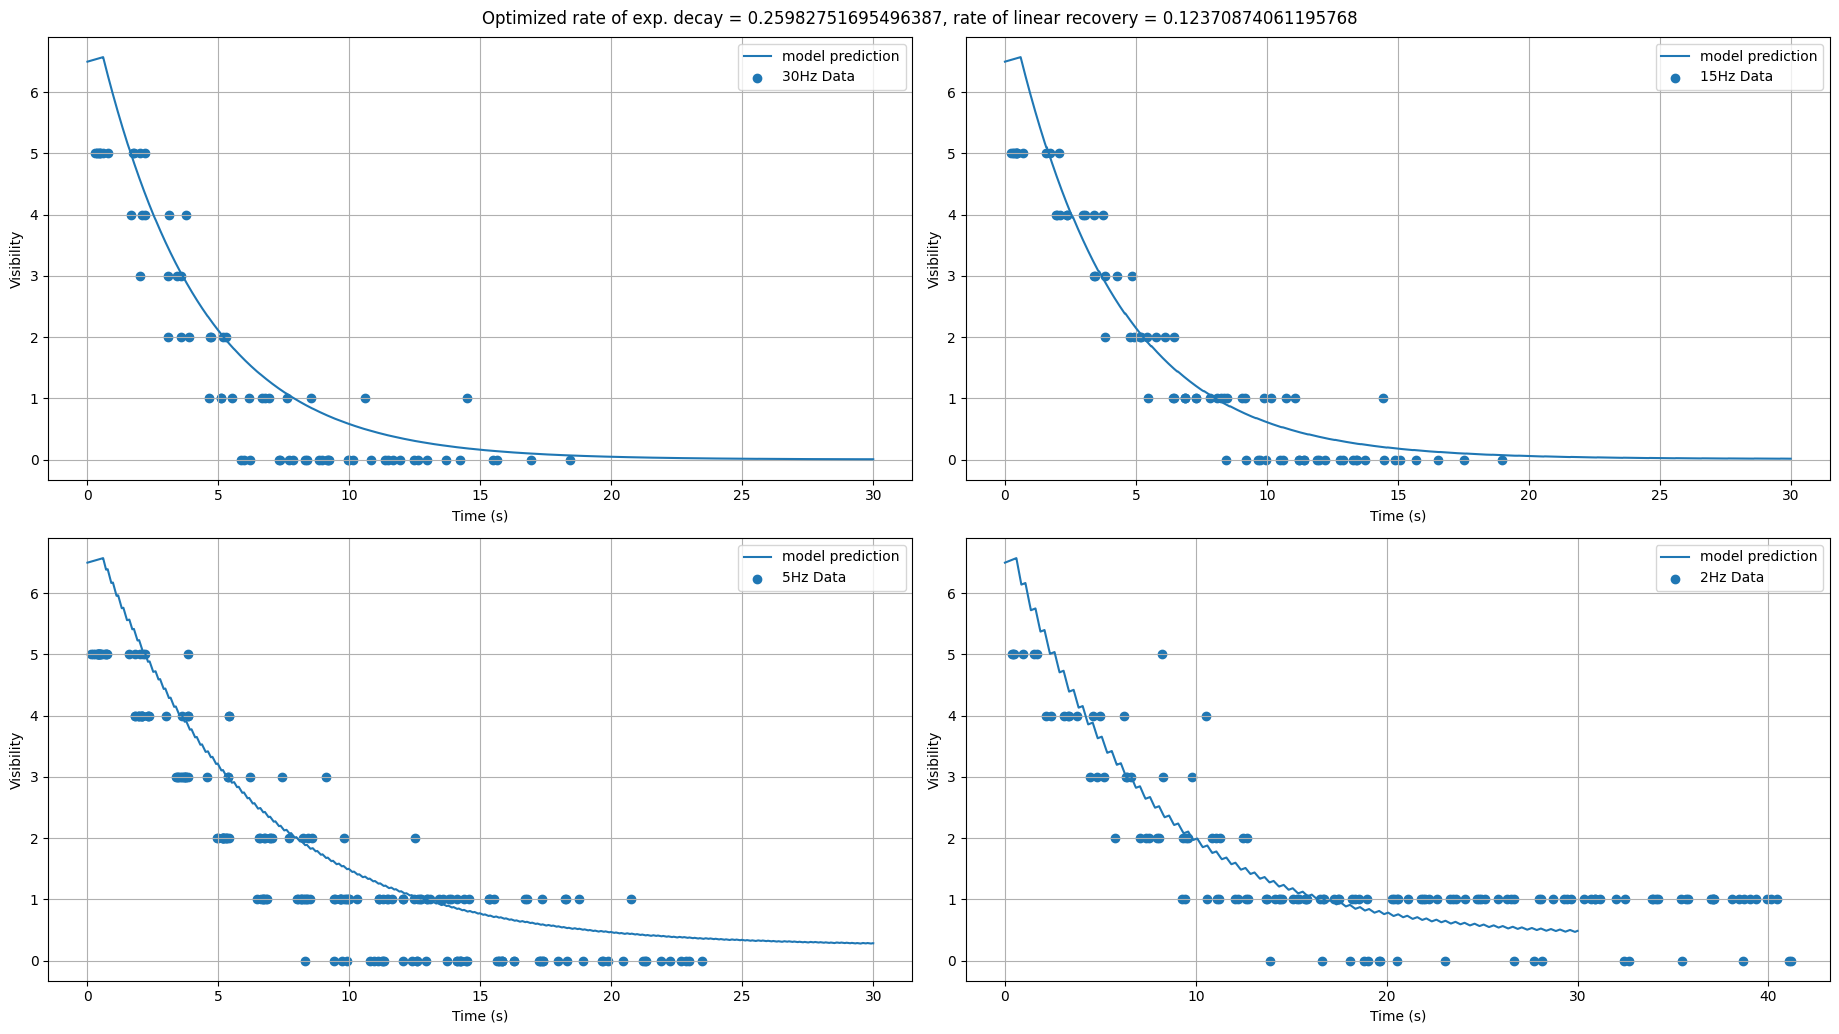

In [16]:
# Optimize rate of desensitization, rate of recovery, and smoothing function (cutoff frequency variable) using scipy.optimize.minimize()

# Constants
start_visibility = 6.5
zero_equivalent = 0.00001  # smoothing function resulted in a lot of values very close to zero
total_time = 30       # Total time of simulation (arbitrary units)
dt = 0.001            # Time step size is now millisecond to match stim arrays
num_steps = int(total_time / dt)

# Create a DataFrame to store time, stimuli, and predicted visibility
time = np.linspace(0, total_time, num_steps)
df = pd.DataFrame({'time': time})

# dict of stims:

stims = {
    '30Hz': 30,
    '15Hz': 15,
    '5Hz': 5,
    '2Hz': 2
}

# Function to initialize stimuli columns with specified cuttoff_freqency in a DF
def create_stims(df, cutoff_freq):

    # Stimuli data
    stimuli_data = {
        '30Hz': one_sec_smoothed_signal(30, cutoff_freq),
        '15Hz': one_sec_smoothed_signal(15, cutoff_freq),
        '5Hz': one_sec_smoothed_signal(5, cutoff_freq),
        '2Hz': one_sec_smoothed_signal(2, cutoff_freq)
    }
    
    for freq, stimulus in stimuli_data.items():
        stimulus_repeated = np.tile(stimulus, int(total_time))
        padded_stimulus = np.concatenate((np.zeros(600), stimulus_repeated))
        # Ensure the length matches num_steps (cut off last 600ms of stimuli)
        padded_stimulus = padded_stimulus[:num_steps]
        df[f'padded_stimulus_{freq}'] = padded_stimulus
        df[f'visibility_{freq}'] = np.zeros(num_steps)
        df.at[0, f'visibility_{freq}'] = start_visibility

    return df

# Function to update visibility
def update_visibility(visibility, stimulus, d, r, zero_equivalent, dt):
    if stimulus > zero_equivalent:
        return visibility + rate_of_desensitization(visibility, d) * dt
    else:
        return visibility + r * dt

# Function to perform Euler integration
def euler_integration(df, d, r):
    for i in range(1, num_steps):
        for freq in stims.keys():
            df.at[i, f'visibility_{freq}'] = update_visibility(df.at[i-1, f'visibility_{freq}'], df.at[i, f'padded_stimulus_{freq}'], d, r, zero_equivalent, dt)
    return df

# Cost function to minimize
def cost_function(params):
    d, r, c = params
    df_copy = df.copy()
    df_copy = create_stims(df_copy, c)
    df_copy = euler_integration(df_copy, d, r)
    
    sse = 0 # sum of squared error
    for freq in stims.keys():
        # Interpolating the actual data to match the prediction times
        # First flatten the (xx,) times_ and vis_ that are in the mat dictionary
        actual_times = Exp1_mat[f'times_{freq}'].flatten() if Exp1_mat[f'times_{freq}'].ndim > 1 else Exp1_mat[f'times_{freq}']
        actual_visibilities = Exp1_mat[f'vis_{freq}'].flatten() if Exp1_mat[f'vis_{freq}'].ndim > 1 else Exp1_mat[f'vis_{freq}']
        actual_visibility = np.interp(df_copy['time'], actual_times, actual_visibilities)
        
        # Calculating the sum of squared errors
        sse += np.sum((df_copy[f'visibility_{freq}'] - actual_visibility) ** 2)
    
    return sse

# Initial guess for d, r and c
initial_guess = [0.45, 0.3, 0.03]

# Perform optimization
result = scipy.optimize.minimize(cost_function, initial_guess, method='Nelder-Mead')
optimized_d, optimized_r, optimized_c = result.x

print(f'Optimized d: {optimized_d}, Optimized r: {optimized_r}, Optimized c: {optimized_c}')

# Perform final Euler integration with optimized parameters
df = create_stims(df, optimized_c)
df = euler_integration(df, optimized_d, optimized_r)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(18.5, 10.5))
fig.suptitle(f'Optimized rate of exp. decay = {optimized_d}, rate of linear recovery = {optimized_r}')

for ax, freq in zip(axes.flatten(), stims.keys()):
    ax.plot(df['time'], df[f'visibility_{freq}'], label='model prediction')
    ax.scatter(Exp1_mat[f'times_{freq}'], Exp1_mat[f'vis_{freq}'], label=f'{freq} Data')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Visibility')
    ax.legend()
    ax.grid(visible=True)

plt.tight_layout()
plt.show()

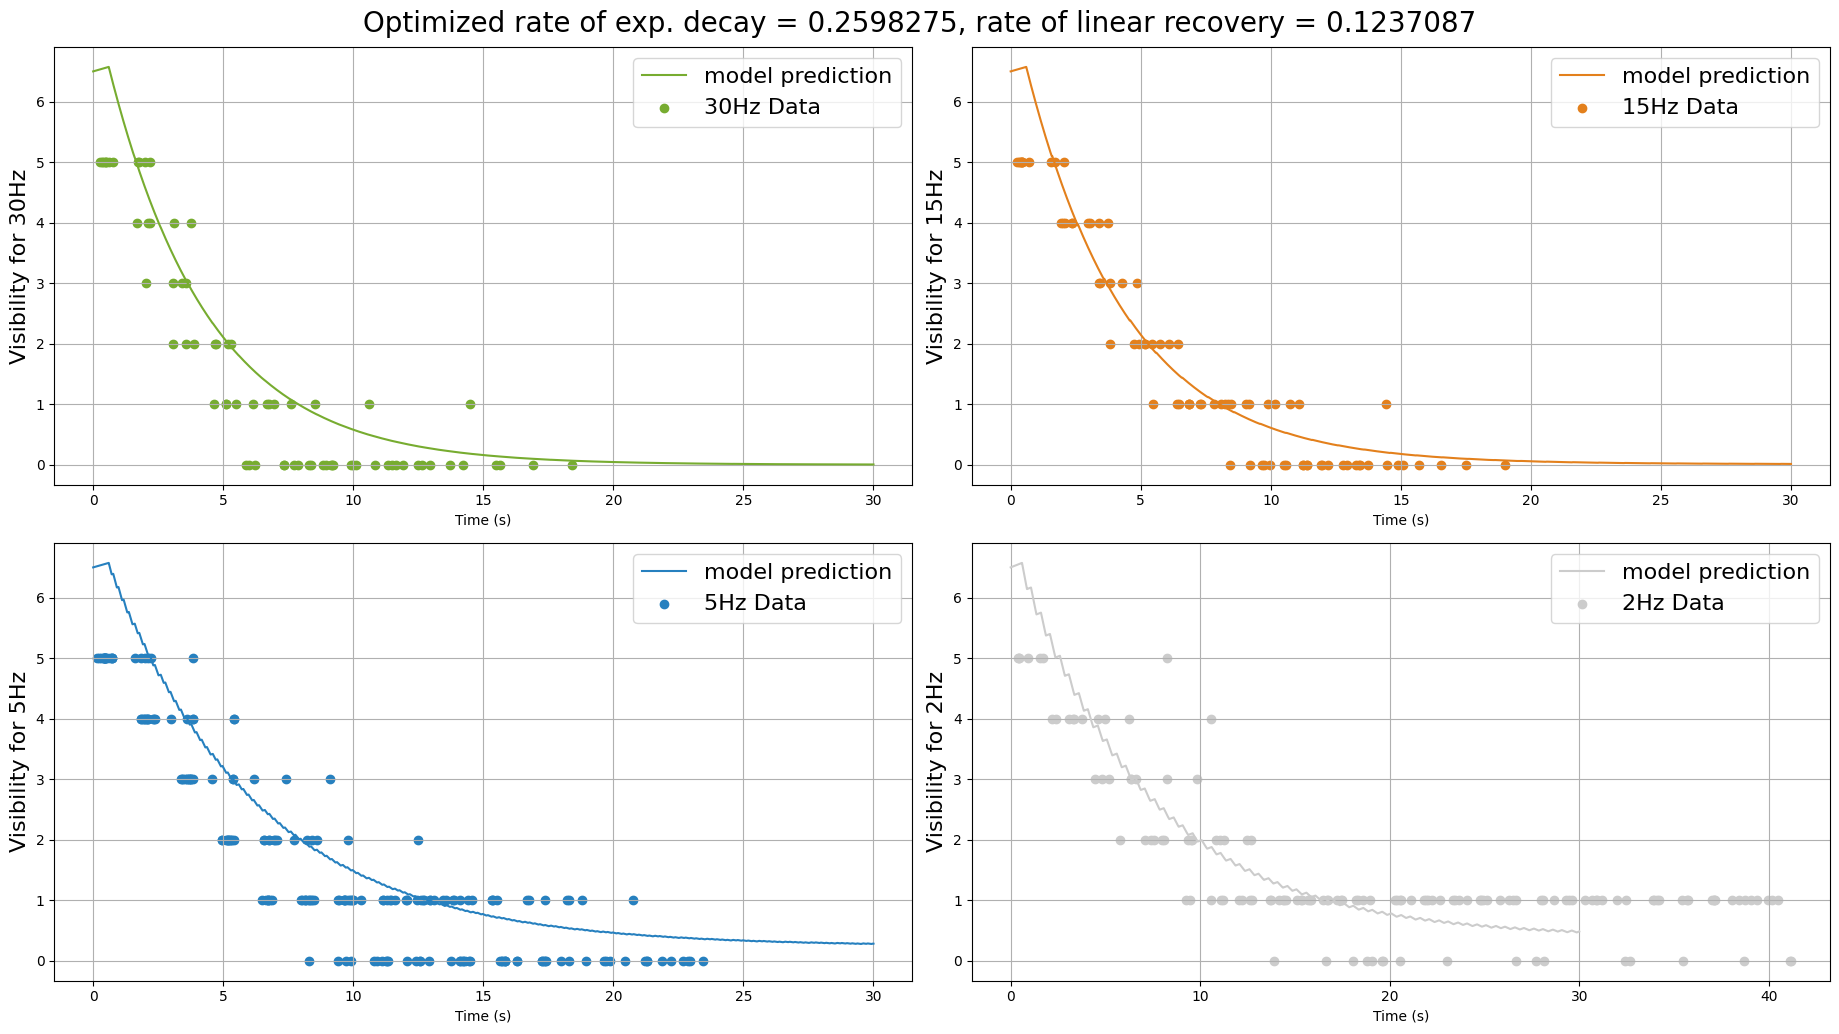

In [18]:
stimuli_colors = {
    '30Hz': mat['green'][0],
    '15Hz': mat['orange'][0],
    '5Hz': mat['blue'][0],
    '2Hz': mat['grey'][0]
}

optimized_d = 0.2598275
optimized_r = 0.1237087

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(18.5, 10.5))
fig.suptitle(f'Optimized rate of exp. decay = {optimized_d}, rate of linear recovery = {optimized_r}', fontsize = 20)

for ax, freq in zip(axes.flatten(), stims.keys()):
    ax.plot(df['time'], df[f'visibility_{freq}'], label='model prediction', color=stimuli_colors[f'{freq}'])
    ax.scatter(mat[f'times_{freq}'], mat[f'vis_{freq}'], label=f'{freq} Data', color=stimuli_colors[f'{freq}'])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Visibility for {freq}', fontsize = 16)
    ax.legend(fontsize = 16)
    ax.grid(visible=True)

plt.tight_layout()
plt.show()

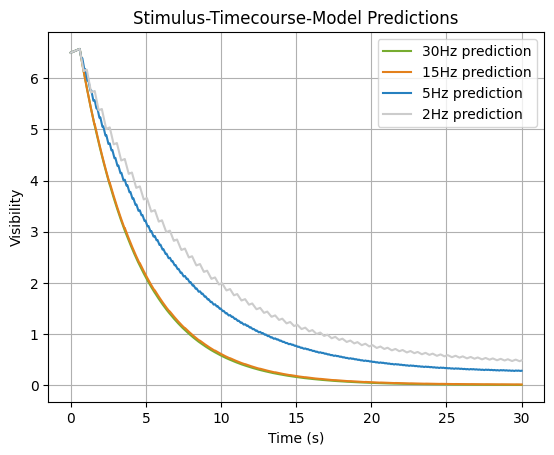

In [20]:
# Plot just the curves together
for freq in stims.keys():
    plt.plot(df['time'], df[f'visibility_{freq}'], label=f'{freq} prediction', color=stimuli_colors[freq])
    #plt.scatter(mat[f'times_{freq}'], mat[f'vis_{freq}'], label=f'{freq} Data', color=stimuli_colors[freq])
    plt.xlabel('Time (s)')
    plt.ylabel('Visibility')
    
# plt.title(f'Decay rate = {optimized_d}, recovery rate = {optimized_r}')
plt.title('Stimulus-Timecourse-Model Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Optimizing Approach 3 

In [7]:
# Define the rate of adaptation growth
# this is the same as the "desensitization rate" equation in my simple model
def adaptation_growth(adaptation, g):
    return adaptation * g

In [8]:
# Define rate of adaptation decay
# making this nonlinear, as opposed to the linear recovery in approach #2
def adaptation_decay(adaptation, recovery):
    return recovery * adaptation

Optimized d: 0.4257214907057238, Optimized r: 0.289532761046008, Optimized c: 0.03133259949602674, Optimized s: 5.206660282558242


NameError: name 'mat' is not defined

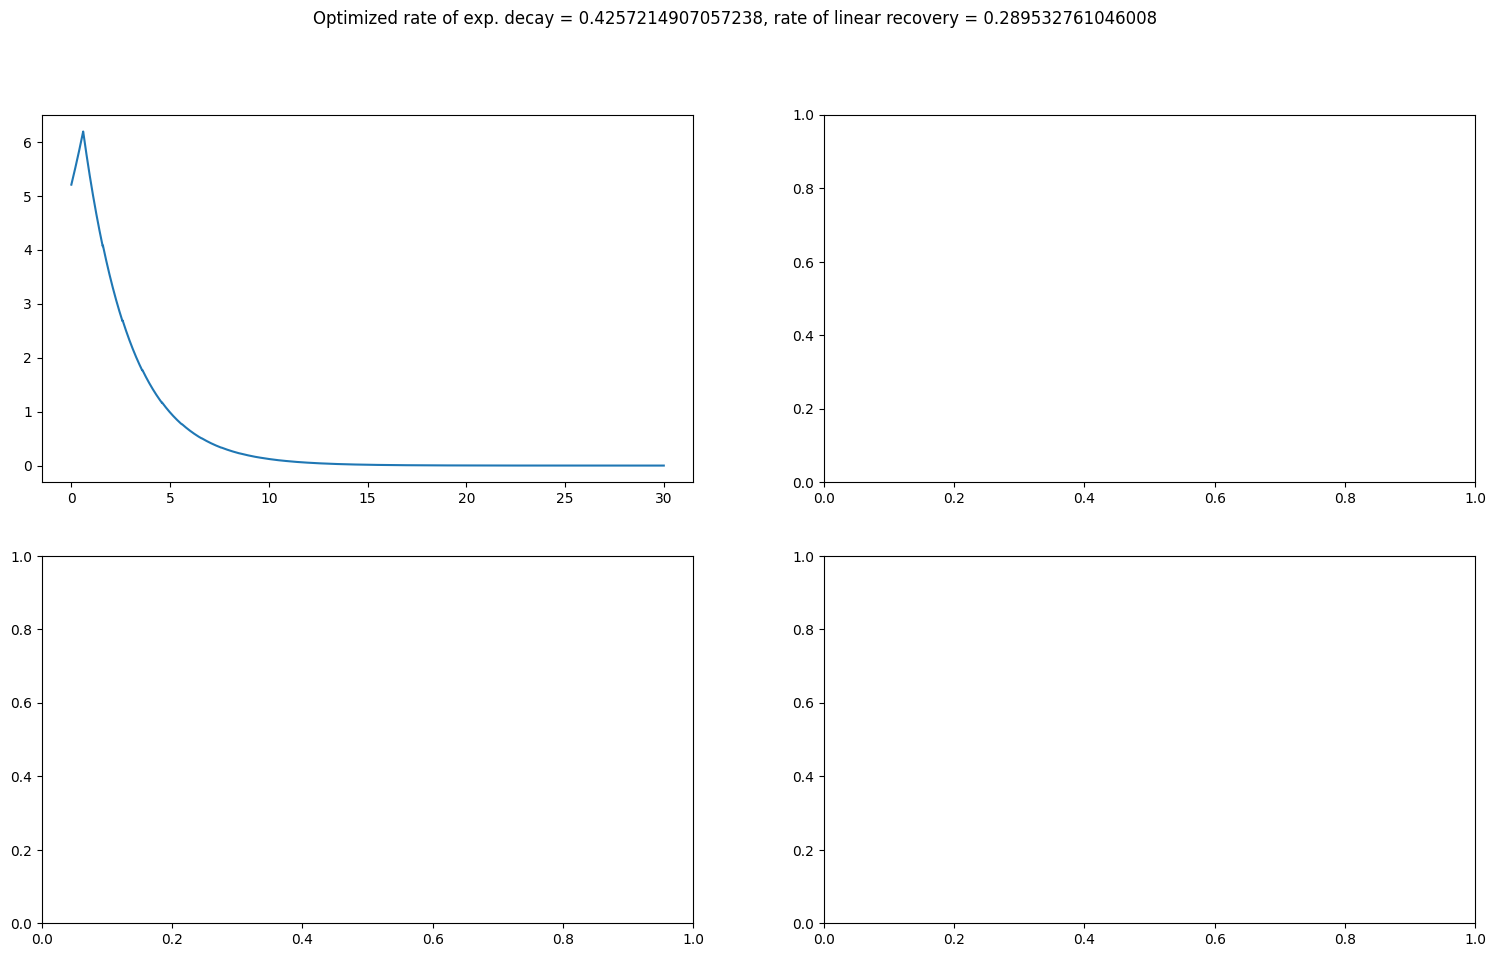

In [10]:
# Optimize rate of desensitization, rate of recovery, and smoothing function (cutoff frequency variable) using scipy.optimize.minimize()

# Constants
zero_equivalent = 0.0001  # smoothing function resulted in a lot of values very close to zero
total_time = 30       # Total time of simulation (arbitrary units)
dt = 0.001            # Time step size is now millisecond to match stim arrays
num_steps = int(total_time / dt)

# Create a DataFrame to store time, stimuli, and predicted visibility
time = np.linspace(0, total_time, num_steps)
df = pd.DataFrame({'time': time})

# dict of stims:

stims = {
    '30Hz': 30,
    '15Hz': 15,
    '5Hz': 5,
    '2Hz': 2
}

# Function to initialize stimuli columns with specified cuttoff_freqency in a DF
def create_stims(df, cutoff_freq, start_visibility):

    # Stimuli data
    stimuli_data = {
        '30Hz': one_sec_smoothed_signal(30, cutoff_freq),
        '15Hz': one_sec_smoothed_signal(15, cutoff_freq),
        '5Hz': one_sec_smoothed_signal(5, cutoff_freq),
        '2Hz': one_sec_smoothed_signal(2, cutoff_freq)
    }
    
    for freq, stimulus in stimuli_data.items():
        stimulus_repeated = np.tile(stimulus, int(total_time))
        padded_stimulus = np.concatenate((np.zeros(600), stimulus_repeated))
        # Ensure the length matches num_steps (cut off last 600ms of stimuli)
        padded_stimulus = padded_stimulus[:num_steps]
        df[f'padded_stimulus_{freq}'] = padded_stimulus
        df[f'visibility_{freq}'] = np.zeros(num_steps)
        df.at[0, f'visibility_{freq}'] = start_visibility

    return df

# Function to update visibility
def update_visibility(visibility, stimulus, d, r, zero_equivalent, dt):
    if stimulus > zero_equivalent:
        return visibility - adaptation_growth(visibility, d) * dt
    else:
        return visibility + adaptation_decay(visibility, r) * dt

# Function to perform Euler integration
def euler_integration(df, d, r):
    for i in range(1, num_steps):
        for freq in stims.keys():
            df.at[i, f'visibility_{freq}'] = update_visibility(df.at[i-1, f'visibility_{freq}'], df.at[i, f'padded_stimulus_{freq}'], d, r, zero_equivalent, dt)
    return df

# Cost function to minimize
def cost_function(params):
    d, r, c, s = params
    df_copy = df.copy()
    df_copy = create_stims(df_copy, c, s)
    df_copy = euler_integration(df_copy, d, r)
    
    sse = 0 # sum of squared error
    for freq in stims.keys():
        # Interpolating the actual data to match the prediction times
        # First flatten the (xx,) times_ and vis_ that are in the mat dictionary
        actual_times = Exp1_mat[f'times_{freq}'].flatten() if Exp1_mat[f'times_{freq}'].ndim > 1 else Exp1_mat[f'times_{freq}']
        actual_visibilities = Exp1_mat[f'vis_{freq}'].flatten() if Exp1_mat[f'vis_{freq}'].ndim > 1 else Exp1_mat[f'vis_{freq}']
        actual_visibility = np.interp(df_copy['time'], actual_times, actual_visibilities)
        
        # Calculating the sum of squared errors
        sse += np.sum((df_copy[f'visibility_{freq}'] - actual_visibility) ** 2)
    
    return sse

# Initial guess for d, r, c and s
initial_guess = [0.45, 0.3, 0.03, 6.5]

# Perform optimization
result = scipy.optimize.minimize(cost_function, initial_guess, method='Nelder-Mead')
optimized_d, optimized_r, optimized_c, optimized_s = result.x

print(f'Optimized d: {optimized_d}, Optimized r: {optimized_r}, Optimized c: {optimized_c}, Optimized s: {optimized_s}')


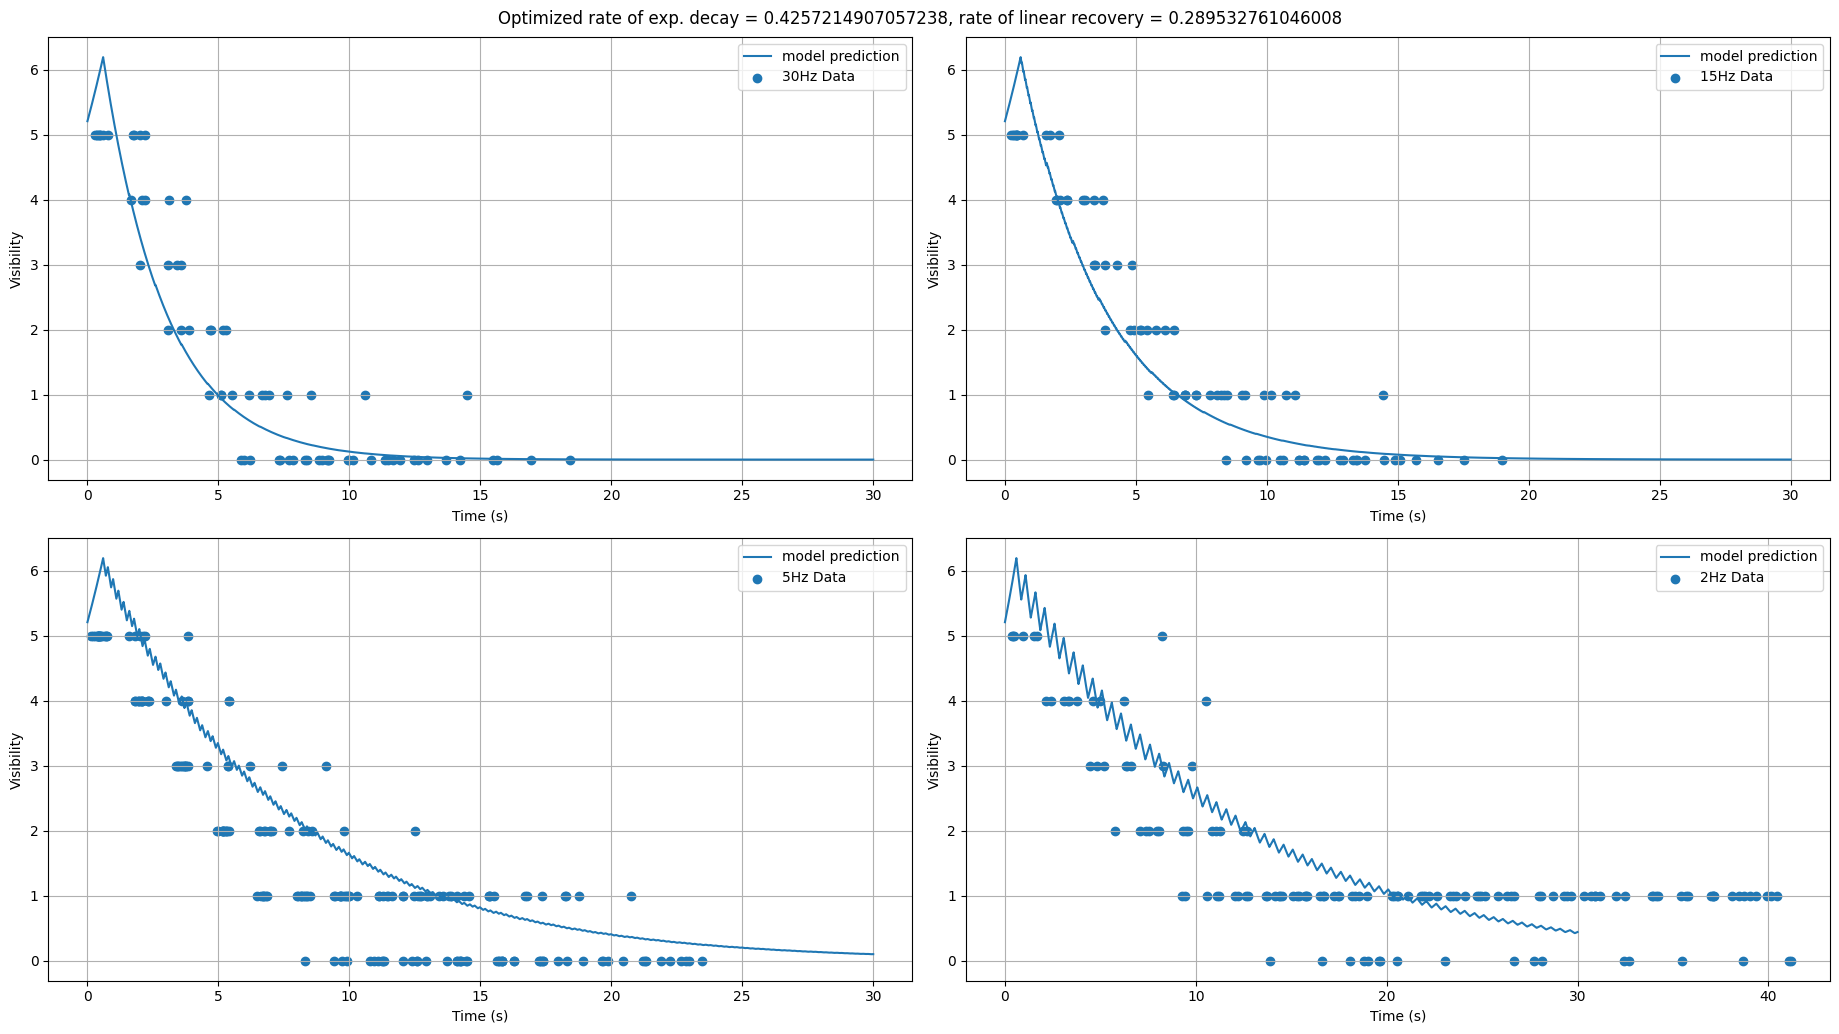

In [12]:
# Perform final Euler integration with optimized parameters
df = create_stims(df, optimized_c, optimized_s)
df = euler_integration(df, optimized_d, optimized_r)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(18.5, 10.5))
fig.suptitle(f'Optimized rate of exp. decay = {optimized_d}, rate of recovery = {optimized_r}')

for ax, freq in zip(axes.flatten(), stims.keys()):
    ax.plot(df['time'], df[f'visibility_{freq}'], label='model prediction')
    ax.scatter(Exp1_mat[f'times_{freq}'], Exp1_mat[f'vis_{freq}'], label=f'{freq} Data')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Visibility')
    ax.legend()
    ax.grid(visible=True)

plt.tight_layout()
plt.show()

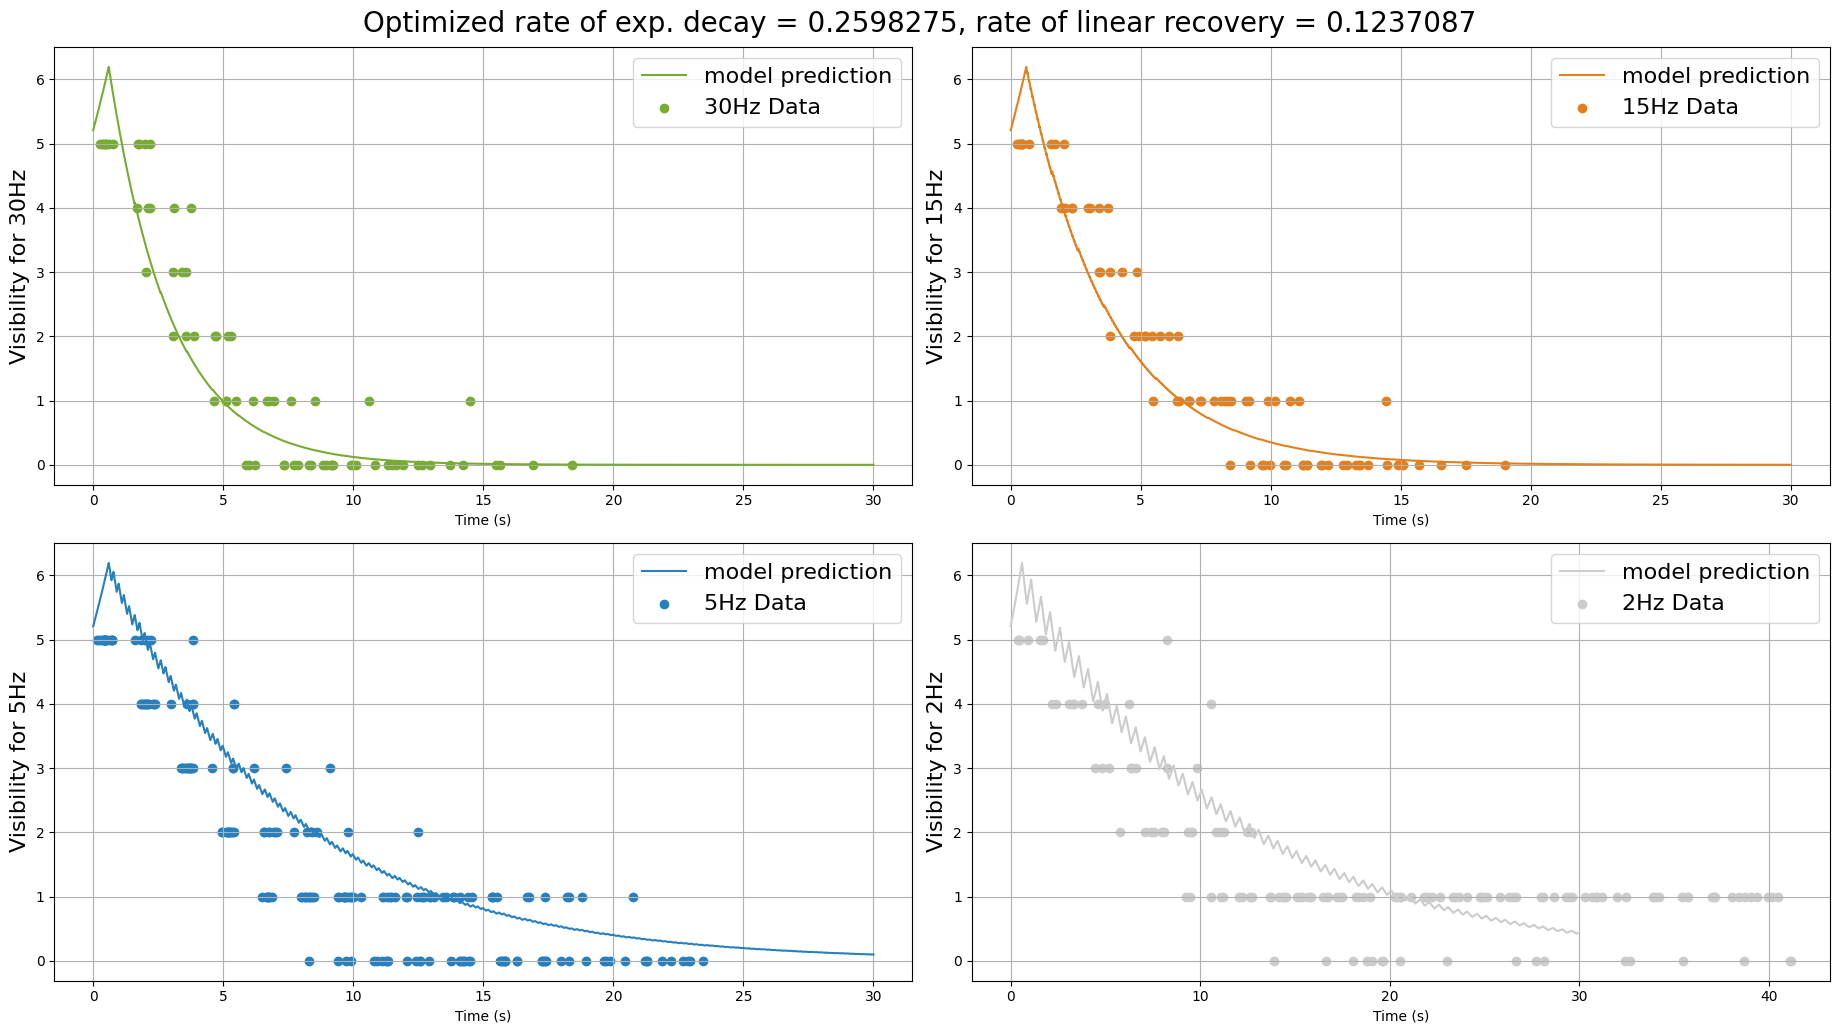

In [13]:
stimuli_colors = {
    '30Hz': Exp1_mat['green'][0],
    '15Hz': Exp1_mat['orange'][0],
    '5Hz': Exp1_mat['blue'][0],
    '2Hz': Exp1_mat['grey'][0]
}

optimized_d = 0.2598275
optimized_r = 0.1237087

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(18.5, 10.5))
fig.suptitle(f'Optimized rate of exp. decay = {optimized_d}, rate of linear recovery = {optimized_r}', fontsize = 20)

for ax, freq in zip(axes.flatten(), stims.keys()):
    ax.plot(df['time'], df[f'visibility_{freq}'], label='model prediction', color=stimuli_colors[f'{freq}'])
    ax.scatter(Exp1_mat[f'times_{freq}'], Exp1_mat[f'vis_{freq}'], label=f'{freq} Data', color=stimuli_colors[f'{freq}'])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Visibility for {freq}', fontsize = 16)
    ax.legend(fontsize = 16)
    ax.grid(visible=True)

plt.tight_layout()
plt.show()

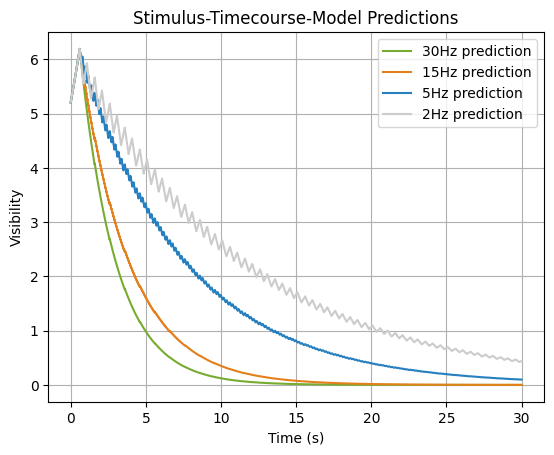

In [14]:
# Plot just the curves together
for freq in stims.keys():
    plt.plot(df['time'], df[f'visibility_{freq}'], label=f'{freq} prediction', color=stimuli_colors[freq])
    #plt.scatter(Exp1_mat[f'times_{freq}'], Exp1_mat[f'vis_{freq}'], label=f'{freq} Data', color=stimuli_colors[freq])
    plt.xlabel('Time (s)')
    plt.ylabel('Visibility')
    
# plt.title(f'Decay rate = {optimized_d}, recovery rate = {optimized_r}')
plt.title('Stimulus-Timecourse-Model Predictions')
plt.legend()
plt.grid(True)
plt.show()